# Latent Dirichlet Allocation
## NPFL097 Assignment 1
### Jiří Balhar

In this notebook I use my implementation of LDA topic model to analyse a collection of 18000 news posts from 20newsgroups dataset. This notebook is divided into 6 sections following the assignment structure. For each task I show the task assignment, solution code, required outputs and my comment, if needed.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from lda import LDATopicModel, load_data, train

In [4]:
# load cached data if available
cache_path = "preprocessed_20newsgroups.pickle"
if os.path.isfile(cache_path):
    with open(cache_path, "rb") as f:
        docs, docs_test, dictionary = pickle.load(f)
else:
    docs, docs_test, dictionary = load_data()
    # save docs and dictionary to cache using pickle
    with open(cache_path, "wb") as f:
        pickle.dump((docs, docs_test, dictionary), f)

# also load the original data
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset="train")

## Task 1
Implement the Latent Dirichlet allocation topic model, as described in
the previous lectures. Set the hyperparameters α = 0.1, γ = 0.1 and set
number of topics K = 20.

In [68]:
topics = 20
alpha = 0.1
gamma = 0.1
seed = 42
perplexities, model = train(docs, dictionary, "./", iterations=100, topics=20, alpha=alpha, gamma=gamma, seed=seed, save_each=1)

Iteration 1, PP=2575.074808582371, Time=0.63
Iteration 2, PP=2518.810285465133, Time=0.6
Iteration 3, PP=2432.6500562911824, Time=0.57
Iteration 4, PP=2302.201385115215, Time=0.59
Iteration 5, PP=2135.5984685009976, Time=0.58
Iteration 6, PP=1969.235993089717, Time=0.59
Iteration 7, PP=1834.9041143649085, Time=0.57
Iteration 8, PP=1735.7998273467572, Time=0.62
Iteration 9, PP=1660.5631506905, Time=0.51
Iteration 10, PP=1601.7507407768112, Time=0.59
Iteration 11, PP=1552.9722780195307, Time=0.59
Iteration 12, PP=1513.5614253856252, Time=0.62
Iteration 13, PP=1480.2687856616444, Time=0.5
Iteration 14, PP=1451.1607965117385, Time=0.66
Iteration 15, PP=1427.2984477696014, Time=0.56
Iteration 16, PP=1407.4487498932015, Time=0.72
Iteration 17, PP=1390.3792202474795, Time=0.58
Iteration 18, PP=1375.8280874645677, Time=0.66
Iteration 19, PP=1363.777232452039, Time=0.54
Iteration 20, PP=1353.530961156823, Time=0.78
Iteration 21, PP=1344.583646011528, Time=0.53
Iteration 22, PP=1336.314818915834

## Task 2
Plot the distribution over topics for the longest document in the data after
initialization and after 1st, 2nd, 5th, 10th, 20th, 50th, and 100th iteration.
Comment on these. 

In [67]:
# show the longest document
max_len_document = np.array([len(d) for d in docs]).argmax()

print("First 30 tokens of the longest document:")
print(" ".join(dictionary[x] for x in docs[max_len_document][:30]))
print("Original category:", newsgroups_train.target_names[newsgroups_train.target[max_len_document]])
print("Original text (first 500 characters):")
print(newsgroups_train.data[max_len_document][:500])

First 30 tokens of the longest document:
stein washington mitch sport hockey frequent ask question univers washington expir repli washington nntp host stein washington archiv hockey sport hockey answer frequent ask question news content info minor leagu
Original category: rec.sport.hockey
Original text (first 500 characters):
From: hamlet@stein.u.washington.edu (Mitch McGowan)
Subject: rec.sport.hockey Frequently Asked Questions
Organization: University of Washington
Lines: 1768
Expires: Mon, 03 May 93 00:00:01 EDT
Reply-To: hamlet@u.washington.edu
NNTP-Posting-Host: stein.u.washington.edu

Archive-name: hockey-faq

rec.sport.hockey answers to Frequently Asked Questions and other news:
 
Contents:

0. New Info.
1. NHL
2. NHL Minor Leagues
3. College Hockey (North America)
4. Other leagues (e.g. Europe, Canada Cup tou


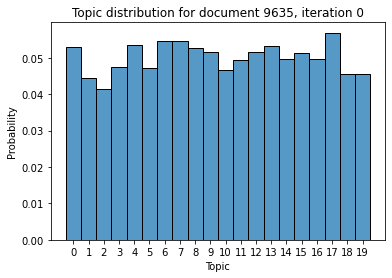

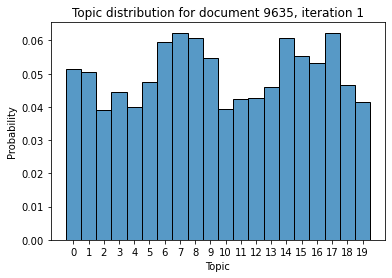

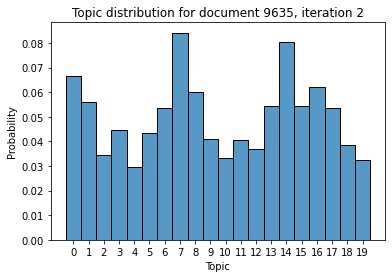

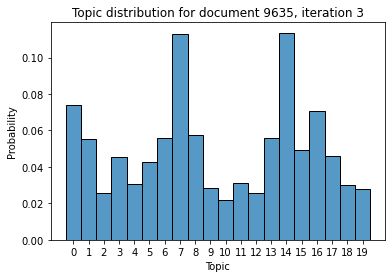

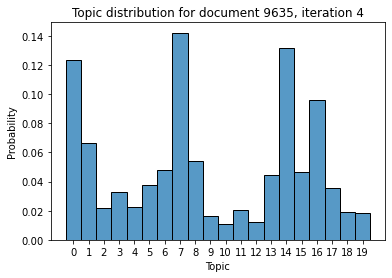

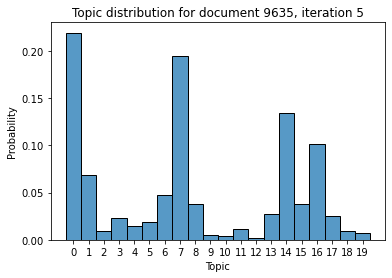

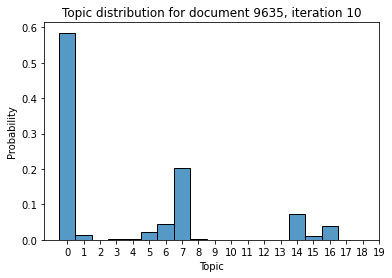

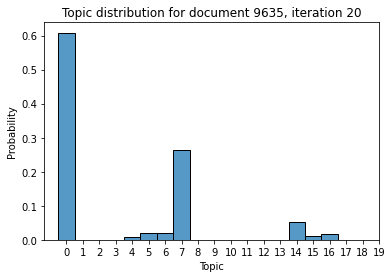

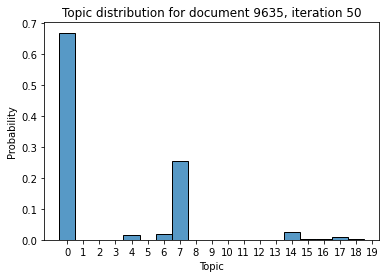

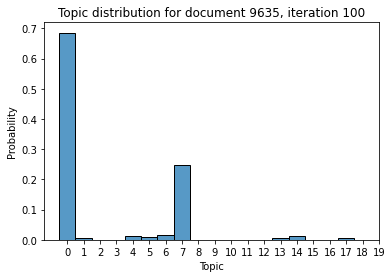

In [69]:
result_dir = "./ldamodel_topics20_alpha0.1_gamma0.1_iterations100_seed42"
for it in [0, 1, 2, 3, 4, 5, 10, 20, 50, 100]:
    model.load(os.path.join(result_dir, f"model_{it}.pickle"))
    document = model.z_nd[max_len_document]

    ax = sns.histplot(document, stat="probability", discrete=True)
    ax.set_title(f"Topic distribution for document {max_len_document}, iteration {it}")
    ax.set_xlabel("Topic")
    ax.set_xticks(range(topics))
    ax.set_xticklabels(range(topics))
    plt.show()

Based on the document excerpt, the longest article is most likely about sports. 

Now let's look at the probability distribution over topics for this document after each iteration. We can see that the distribution is nearly uniform at the start. This makes sense because we have initialized the topics uniformly for each word. After 10 iterations we can see that the majority of the distribution mass shifts towards topic 0 and 7. Throughout the rest of the iterations the distribution becomes more and more concentrated on topic 0 and topic 7. At the 100th iteration the probability of the topic 0 is ~0.7 and probability of topic 7 is ~0.25.

We can hypothesize that the LDA model has converged to a solution where topic 0 is about sports. We will look at the top 20 words for this and the second most probable topic later in the notebook.

## Task 3
Compute the word entropy for each of the topics as a function of the
number of Gibbs iterations. Plot them all in one figure. 

In [96]:
iterations = 100
H_ki = [[] for i in range(topics)]

for it in range(iterations):
    model.load(os.path.join(result_dir, f"model_{it}.pickle"))
    for k in range(topics):
        H_ki[k].append(model.entropy_topic(k))

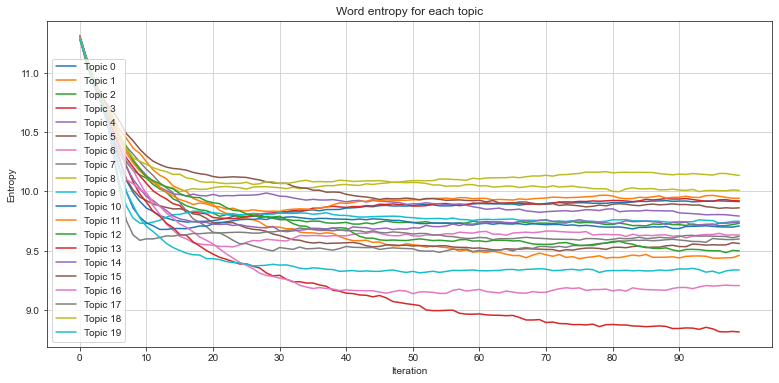

In [98]:
plt.figure(figsize=(13,6))
sns.set_style("ticks",{'axes.grid' : True})
for k, H_k in enumerate(H_ki):
    ax = sns.lineplot(x=np.arange(iterations), y=H_k, label=f"Topic {k}")
    ax.set_title(f"Word entropy for each topic")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Entropy")
    xticks = range(0, iterations, 10)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    #plt.show()

As we can see from the plot, the word entropy decreases with the number of iterations. This is expected because the model is getting better at estimating the topic distribution for each word. The largest decrease in the word entropy is in the first 10 iterations. After that the decrease is much smaller as the model converges to a solution.

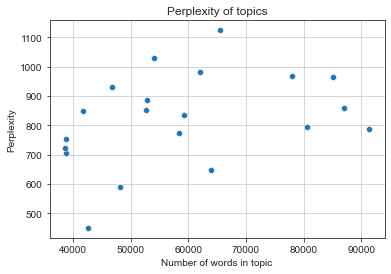

In [99]:
# NOTE: This unused code was inteded to compare the perplexity of a topic and the number of words in the topic. 
# I wanted to look into why some of the topics have higher perplexity than others. The number of words in the topic 
# correlates with perplexity and thus could be a reason but it surely not the only reason.


H_last = [H_k[-1] for H_k in H_ki]
total_word_counts = np.sum(model.c_w, axis=0)
# compute the perplexities from the entropy and zip it with the number of words per topic
perplexities = [(2**H_k, c_w) for H_k, c_w in zip(H_last, total_word_counts)]
# plot the perplexities against the number of words per topic
ax = sns.scatterplot(x=[c_w for _, c_w in perplexities], y=[p for p, _ in perplexities])
ax.set_title(f"Perplexity of topics")
ax.set_xlabel("Number of words in topic")
ax.set_ylabel("Perplexity")
plt.show()


## Task 4
Show histograms of the most frequent 20 words of three chosen topics after 100 Gibbs iterations. What are the chosen topics about?

Top 20 words for topic 0:


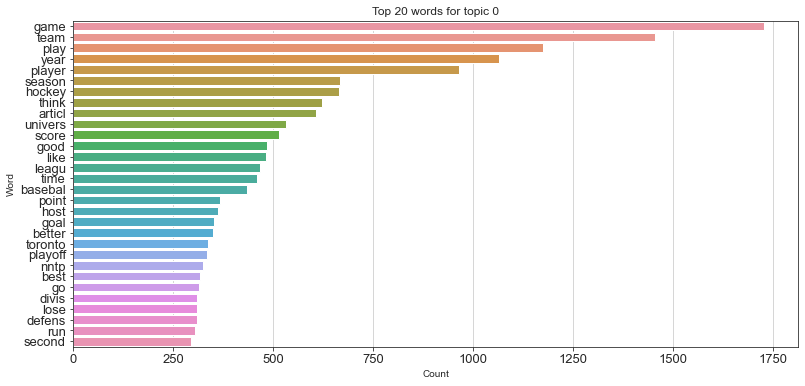

Top 20 words for topic 7:


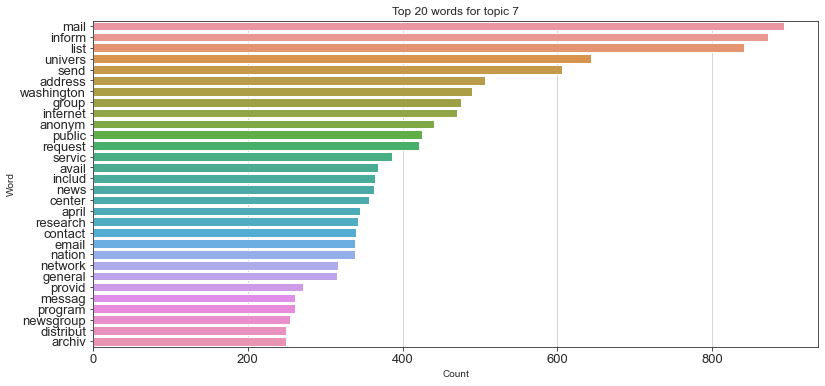

Top 20 words for topic 14:


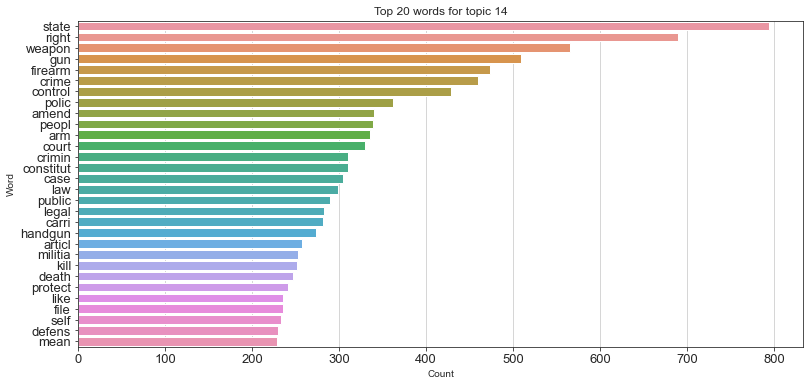

In [100]:
model.load(os.path.join(result_dir, f"model_100.pickle"))
for k in [0, 7, 14]:
    print(f"Top 20 words for topic {k}:")
    top_words_with_counts = model.top_words(k, topn=30)
    # print(top_words_with_counts)
    # plot barplot of top 20 words using seaborn
    # set the figure size
    plt.figure(figsize=(13,6))
    ax = sns.barplot(x=[c for _, c in top_words_with_counts], y=[w for w, _ in top_words_with_counts])
    # set larger font size
    ax.tick_params(labelsize=13)
    ax.set_title(f"Top 20 words for topic {k}")
    ax.set_xlabel("Count")
    ax.set_ylabel("Word")
    plt.show()


Here we look at the top 20 words for topics 0, 7 and 14 which we found to be the most likely topics for the longest article in the dataset.

The most probable words for topic 0 are: game, team, play, year, player, ... This supports our hypothesis that topic 0 is about sports.

The topic 7 contains words like: mail, list, inform, send, ... messag, email, news. The topic is a little more difficult to interpret but it appears to be about the internet and communication.

The topic 14 is much clearer. The most probable words are state, right, weapon, firearm, control, public, ... This topic is about gun control, crime and the law.

To get more insight into the topic 3 which was harder to interpret, we can look at some of the articles from the dataset which are most likely to be about this topic.

In [108]:
chosen_topic = 7
c_d = np.array(model.c_d)
article_probabilities = c_d / np.sum(c_d, axis=1)[:, np.newaxis]
article_probabilities = article_probabilities[:, chosen_topic]

# find articles with highest probability for chosen topic
top_articles = np.argsort(article_probabilities)[::-1][:3]
for i, article in enumerate(top_articles):
    print(f"Article {i}:")
    print(newsgroups_train.data[article][:500])
    print("-"*80)
    

Article 0:
From: lipman@oasys.dt.navy.mil (Robert Lipman)
Subject: CALL FOR PRESENTATIONS: Navy SciViz/VR Seminar
Article-I.D.: oasys.32850
Expires: 30 Apr 93 04:00:00 GMT
Reply-To: lipman@oasys.dt.navy.mil (Robert Lipman)
Distribution: usa
Organization: Carderock Division, NSWC, Bethesda, MD
Lines: 65


			CALL FOR PRESENTATIONS
	
      NAVY SCIENTIFIC VISUALIZATION AND VIRTUAL REALITY SEMINAR

			Tuesday, June 22, 1993

	    Carderock Division, Naval Surface Warfare Center
	      (formerly the David Tayl
--------------------------------------------------------------------------------
Article 1:
From: brian@mdavcr.mda.ca (Brian Lemire)
Subject: Joining the X Consortium ????
Organization: MacDonald Dettwiler, 13800 Commerce Parkway, Richmond, BC, Canada  V6V 2J3
Lines: 6

Hi,

	Does anyone have any information on joining the X Consortium ? What
are the costs, what are the benefits, who should I contact ? Thanks



------------------------------------------------------------------------

Looking at the top 3 articles from the topic 7 we can see that this topic might reflect more the form rather than the content of the articles. The articles seem to be actually emails. If we then look at the longest article we were inspecting earlier, we can see that it is also an email. This might explain why the topic 7 is the second most probable topic for this article.

In [102]:
# NOTE: Unused code for inspecting the lowest and highest perplexity topics

H_last = [H_k[-1] for H_k in H_ki]

model.load(os.path.join(result_dir, f"model_100.pickle"))
print("Words for lowest and highest perplexity")
H_sorted = np.argsort(H_last)
for k in [H_sorted[0], H_sorted[-1]]:
    print(f"Top 20 words for topic {k}, PP={2**model.entropy_topic(k)}:")
    print(model.top_words(k, topn=20))

Words for lowest and highest perplexity
Top 20 words for topic 13, PP=450.2286380463407:
[('nntp', 1435.0), ('host', 1401.0), ('univers', 1321.0), ('articl', 920.0), ('thank', 643.0), ('state', 582.0), ('ohio', 561.0), ('know', 555.0), ('repli', 501.0), ('distribut', 500.0), ('cwru', 484.0), ('cleveland', 438.0), ('mail', 377.0), ('freenet', 376.0), ('netcom', 344.0), ('engin', 309.0), ('like', 308.0), ('utexa', 304.0), ('mark', 289.0), ('magnus', 281.0)]
Top 20 words for topic 8, PP=1128.5213442123763:
[('articl', 890.0), ('bike', 740.0), ('like', 662.0), ('drive', 546.0), ('good', 443.0), ('car', 423.0), ('time', 417.0), ('look', 410.0), ('think', 407.0), ('host', 383.0), ('nntp', 360.0), ('engin', 357.0), ('speed', 330.0), ('know', 330.0), ('motorcycl', 323.0), ('road', 317.0), ('thing', 297.0), ('ride', 293.0), ('go', 292.0), ('right', 286.0)]


## Task 5
Preprocess the test data in the same way as the training data. For filtration, use the dictionary from the training data. Compute the per-word perplexity of the test data for the state after 50 Gibbs iterations. Compare it to a simple bayesian model not using any hidden variables and using only one distribution over words β for all documents with symmetric Dirichlet prior with and concentration parameter γ = 0.1.

In [104]:
model.load(os.path.join(result_dir, f"model_100.pickle"))

test_data = docs_test
flat_docs, docs_lengths, c_d = model.assign_topics(test_data, 50)
H = model.entropy_data(flat_docs, docs_lengths, c_d)
print(f"Entropy of test data: {H}")
print(f"Perplexity of test data: {2**H}")

Entropy of test data: 10.48962656128371
Perplexity of test data: 1437.7793382877678


In [105]:
H = model.entropy_data(model.flat_docs, model.docs_lengths, model.c_d)
print(f"Entropy of training data: {H}")
print(f"Perplexity of training data: {2**H}")

Entropy of training data: 10.295315031331052
Perplexity of training data: 1256.604582796761


In [106]:
# Here we compute entropy and perplexity for the simple bayesian model
gamma = 0.1
c_w = np.zeros(len(dictionary))
for d in docs:
    for w in d:
        c_w[w] += 1
H = 0

n_words = sum(c_w)
for d in docs:
    for w in d:
        p_w = (gamma + c_w[w]) / (gamma * len(dictionary) + n_words)
        H -= np.log2(p_w)
H = H / n_words
2**H
print(f"Entropy of test data with the bayesian model: {H}")
print(f"Perplexity of test data with the bayesian model: {2**H}")

Entropy of test data with the bayesian model: 11.349631951428972
Perplexity of test data with the bayesian model: 2609.634331234366


As we can see, the perplexity of our LDA model is lower than the perplexity of the simple bayesian model. This means that the LDA model is better at modelling the test data (lower perplexity means that the model is less "surprised" by the test data). Interestingly this is the case even though the bayesian model has an advantage of being constructed directly from the test data - as opposed to the LDA model which is trained on the training data and has not seen the test data before.
We also compare the perplexity on the training data for the LDA model. Compared to the test data perplexity, the training data perplexity is lower. This is expected because the model was trained on the training data and thus should be better at generating it.

## Task 6
Try to change the number of topics K, the hyperparameters α and γ and the number of Gibbs iterations. How the performance changes? Which model has the lowest perplexity?

In [ ]:
import random
import time

results = []
for alpha in [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10]:
    for gamma in [0, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10]:
        for seed in [0, 1, 2]:
            print(f"Training with alpha={alpha}, gamma={gamma}, seed={seed}")
            res = train(docs, dictionary, "hyperparameter_search_numba/", iterations=100, topics=20, alpha=alpha, gamma=gamma, seed=seed)
            # if not skipped
            if res is not None:
                perplexities, model = res
                results.append({
                    "perplexities": perplexities,
                    "model": model,
                    "seed": seed,
                    "alpha": alpha,
                    "gamma": gamma
                })

In [119]:
# save results to file
with open("hyperparameter_search_numba/results.pickle", "wb") as f:
    results_without_model = []
    for result in results:
        results_without_model.append({
            "perplexities": result["perplexities"],
            "seed": result["seed"],
            "alpha": result["alpha"],
            "gamma": result["gamma"]
        })
    pickle.dump(results_without_model, f)

In [120]:
res_pp = []
for result in results:
    for it, PP in result["perplexities"]:
        res_pp.append({
            "iteration": it,
            "perplexity": PP,
            "seed": result["seed"],
            "alpha": result["alpha"],
            "gamma": result["gamma"]
        })


<AxesSubplot: xlabel='iteration', ylabel='perplexity'>

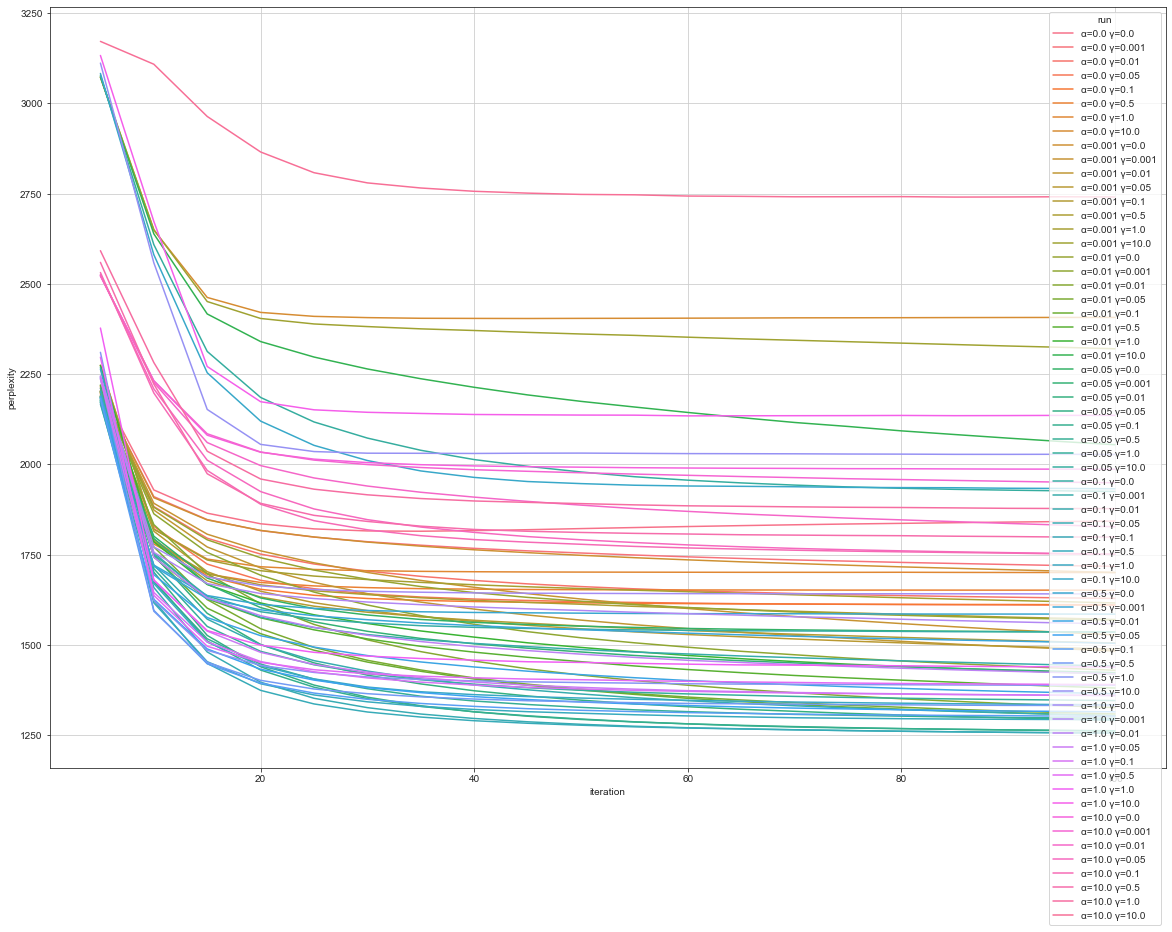

In [121]:
import pandas
df = pandas.DataFrame(res_pp)
# name the runs with utf-8 alpha gamma characters
df["run"] = df["alpha"].apply(lambda x: f"α={x}") + " " + df["gamma"].apply(lambda x: f"γ={x}")
# plot the perplexity for each run, average over the seeds
df_mean = df.groupby(["run", "iteration"]).mean()
# large figure
plt.figure(figsize=(20, 14))
# set log scale for y axis
sns.lineplot(data=df_mean.reset_index(), x="iteration", y="perplexity", hue="run")

In [5]:
topics = 20

res_test_pp = []
with open("./hyperparameter_search_numba/results.pickle", "rb") as f:
    results = pickle.load(f)

test_data = docs_test
# compute test perplexity for the last iteration for each run
for result in results:
    alpha = result["alpha"]
    gamma = result["gamma"]
    seed = result["seed"]
    print("alpha", alpha, "gamma", gamma, "seed", seed)
    model = LDATopicModel(docs, dictionary, topics, alpha, gamma, compute_z_nd=False)
    model.load(f"./hyperparameter_search_numba/ldamodel_topics20_alpha{alpha}_gamma{gamma}_iterations100_seed{seed}/model_100.pickle")
    # print("Model loaded, assign topics")
    flat_docs, docs_lengths, c_d = model.assign_topics(test_data, 50)
    # print("Compute entropy")
    H = model.entropy_data(flat_docs, docs_lengths, c_d)
    PP = 2**H
    # print(f"Entropy of test data: {H}")
    # print(f"Perplexity of test data: {PP}, train data: {result['perplexities'][-1][1]}")
    res_test_pp.append({
        "test_perplexity": PP,
        "train_perplexity": result["perplexities"][-1][1],
        "seed": result["seed"],
        "alpha": alpha,
        "gamma": gamma
    })

alpha 0 gamma 0 seed 0
alpha 0 gamma 0 seed 1
alpha 0 gamma 0 seed 2
alpha 0 gamma 0.001 seed 0
alpha 0 gamma 0.001 seed 1
alpha 0 gamma 0.001 seed 2
alpha 0 gamma 0.01 seed 0
alpha 0 gamma 0.01 seed 1
alpha 0 gamma 0.01 seed 2
alpha 0 gamma 0.05 seed 0
alpha 0 gamma 0.05 seed 1
alpha 0 gamma 0.05 seed 2
alpha 0 gamma 0.1 seed 0
alpha 0 gamma 0.1 seed 1
alpha 0 gamma 0.1 seed 2
alpha 0 gamma 0.5 seed 0
alpha 0 gamma 0.5 seed 1
alpha 0 gamma 0.5 seed 2
alpha 0 gamma 1 seed 0
alpha 0 gamma 1 seed 1
alpha 0 gamma 1 seed 2
alpha 0 gamma 10 seed 0
alpha 0 gamma 10 seed 1
alpha 0 gamma 10 seed 2
alpha 0.001 gamma 0 seed 0
alpha 0.001 gamma 0 seed 1
alpha 0.001 gamma 0 seed 2
alpha 0.001 gamma 0.001 seed 0
alpha 0.001 gamma 0.001 seed 1
alpha 0.001 gamma 0.001 seed 2
alpha 0.001 gamma 0.01 seed 0
alpha 0.001 gamma 0.01 seed 1
alpha 0.001 gamma 0.01 seed 2
alpha 0.001 gamma 0.05 seed 0
alpha 0.001 gamma 0.05 seed 1
alpha 0.001 gamma 0.05 seed 2
alpha 0.001 gamma 0.1 seed 0
alpha 0.001 gamma 0.

In [12]:
np.min(docs_lengths)

3

In [6]:
import pandas as pd
df_test = pd.DataFrame(res_test_pp)
df_test = df_test.groupby(["alpha", "gamma"]).mean().reset_index()

Text(0.5, 1.0, 'Train perplexity heatmap for gridsearch over alpha and gamma')

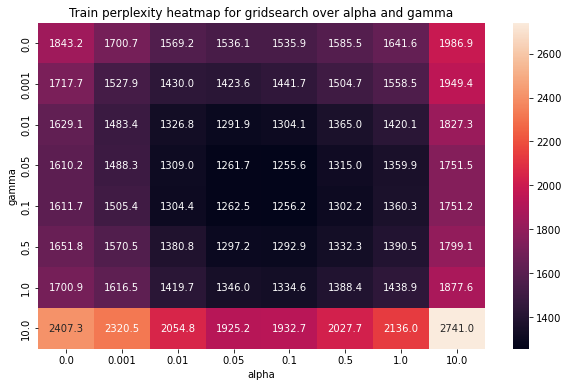

In [7]:
# plot heatmap of last perplexity for each run
df_test_pivot = df_test.pivot(index="gamma", columns="alpha", values="train_perplexity")
plt.figure(figsize=(10,6))
ax = sns.heatmap(df_test_pivot, annot=True, fmt='.1f')
ax.set_title(f"Train perplexity heatmap for gridsearch over alpha and gamma")

Text(0.5, 1.0, 'Test perplexity heatmap for gridsearch over alpha and gamma')

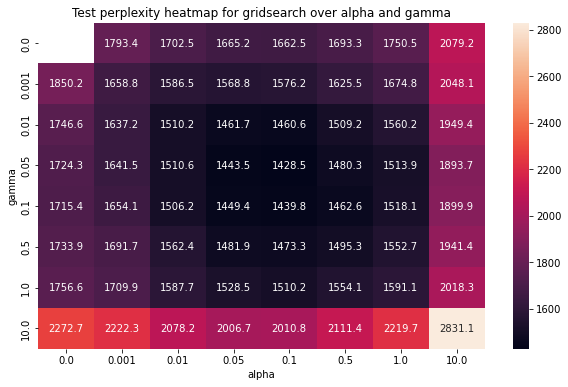

In [8]:
df_test_pivot = df_test.pivot(index="gamma", columns="alpha", values="test_perplexity")
plt.figure(figsize=(10,6))
ax = sns.heatmap(df_test_pivot, annot=True, fmt='.1f')
ax.set_title(f"Test perplexity heatmap for gridsearch over alpha and gamma")

Using an extensive grid search we have found that on our data, LDA performs best with alpha in the interval [0.05, 0.1] and gamma in [0.01, 0.1]. The best test perplexity averaged over 3 random seeds was achieved using settings alpha=0.1 and gamma=0.05. As expected the algorithm does not work well with alpha and gamma > 1. 

For fun, I also tried alpha=0 and gamma=0, even though dirichlet distribution is undefined in these values. If we view the dirichlet prior in a different way - as Laplace smoothing - setting alpha and/or gamma to 0 means using no smoothing for the word counts. This works and the algorithm converges on a valid solution but as expected the results are worse than with smoothing.

In [10]:
res_test_pp[0]

{'test_perplexity': inf,
 'train_perplexity': 1854.8683593423007,
 'seed': 0,
 'alpha': 0,
 'gamma': 0}

In [ ]:
# why inf in alpha=0, gamma=0??

topics = 20

res_test_pp = []
with open("./hyperparameter_search_numba/results.pickle", "rb") as f:
    results = pickle.load(f)

test_data = docs_test


result = results[0]
alpha = result["alpha"]
gamma = result["gamma"]
seed = result["seed"]
print("alpha", alpha, "gamma", gamma, "seed", seed)
model = LDATopicModel(docs, dictionary, topics, alpha, gamma, compute_z_nd=False)
model.load(f"./hyperparameter_search_numba/ldamodel_topics20_alpha{alpha}_gamma{gamma}_iterations100_seed{seed}/model_100.pickle")
# print("Model loaded, assign topics")
flat_docs, docs_lengths, c_d = model.assign_topics(test_data, 50)
# print("Compute entropy")

In [55]:
# H is inf. Therefore there was some zero in np.log2(word_probs)
# (I checked this by debugging the code and looking at the word_probs)

# I obtained the word_probs for the test set from model.entropy_data by hardcoding the lda.py
H, word_probs = model.entropy_data(flat_docs, docs_lengths, c_d)
np.where(word_probs == 0)[0]

/home/jirka/Škola/MFF_WS_2022/NLP_unsupervised/assignment1/lda.py:271: RuntimeWarning: divide by zero encountered in log2
  H = -np.sum(np.log2(word_probs)) / N_test


array([  9582,  52624,  65632, 128952, 307434, 315687, 317770, 320405,
       326302, 337137, 341744, 395043, 412372, 469228, 486987, 614313,
       704940, 718343])

In [66]:
# Lets look at the first word that results in p = 0
# Its index is 9582. Lets modify lda.py so that it prints out debug info for this particular word
model.entropy_data(flat_docs, docs_lengths, c_d)

k	c_d[d][k]	c_w[w][k]	c[k]		p
0	7.0		0.0		48985.0		0.0
1	0.0		0.0		37857.0		0.0
2	0.0		0.0		10328.0		0.0
3	0.0		0.0		23474.0		0.0
4	0.0		0.0		27694.0		0.0
5	0.0		0.0		47139.0		0.0
6	25.0		0.0		10893.0		0.0
7	0.0		13.0		19308.0		0.0
8	0.0		0.0		16525.0		0.0
9	0.0		0.0		15568.0		0.0
10	0.0		0.0		20656.0		0.0
11	0.0		0.0		13904.0		0.0
12	0.0		33.0		27137.0		0.0
13	0.0		18.0		25725.0		0.0
14	0.0		0.0		22219.0		0.0
15	0.0		0.0		21710.0		0.0
16	0.0		0.0		16032.0		0.0
17	0.0		0.0		23412.0		0.0
18	0.0		0.0		30671.0		0.0
19	28.0		0.0		726690.0		0.0


In [67]:
# Here we can see the culprit of the zero probability. The formula for the probability is:
# sum over k:
#     (alpha + c_d[d][k])
#     / KalphaN_d
#     * (gamma + c_w[w][k])
#     / (Mgamma + c[k])

# If we remove all terms containing alpha and gamma (because we consider the =0 case):
# sum over k:
#     c_d[d][k] * c_w[w][k] / (N_d * c[k])

# the denominator is ok - always nonzero
# the numerator is zero if either c_d or c_w is zero. This cannot happen for all k in the case of training data. 
# (the words in document must be always assigned to some topic, therefore for this topic there will be nonzero c_d and c_w)
# But when we compute entropy of test set, we use c_d from test set and c_w from train data. There
# it can happen that the product c_d[d][k] * c_w[w][k] is 0 for all k. We can see this happen in the example above.